In [183]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


### Reading the data

In [184]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


No need for the ID attribute since it's a sequential numbering of the data and the data is already indexed.

In [185]:
df.drop(columns=['Id'], inplace = True)

In [186]:
dict(df.dtypes)

{'MSSubClass': dtype('int64'),
 'MSZoning': dtype('O'),
 'LotFrontage': dtype('float64'),
 'LotArea': dtype('int64'),
 'Street': dtype('O'),
 'Alley': dtype('O'),
 'LotShape': dtype('O'),
 'LandContour': dtype('O'),
 'Utilities': dtype('O'),
 'LotConfig': dtype('O'),
 'LandSlope': dtype('O'),
 'Neighborhood': dtype('O'),
 'Condition1': dtype('O'),
 'Condition2': dtype('O'),
 'BldgType': dtype('O'),
 'HouseStyle': dtype('O'),
 'OverallQual': dtype('int64'),
 'OverallCond': dtype('int64'),
 'YearBuilt': dtype('int64'),
 'YearRemodAdd': dtype('int64'),
 'RoofStyle': dtype('O'),
 'RoofMatl': dtype('O'),
 'Exterior1st': dtype('O'),
 'Exterior2nd': dtype('O'),
 'MasVnrType': dtype('O'),
 'MasVnrArea': dtype('float64'),
 'ExterQual': dtype('O'),
 'ExterCond': dtype('O'),
 'Foundation': dtype('O'),
 'BsmtQual': dtype('O'),
 'BsmtCond': dtype('O'),
 'BsmtExposure': dtype('O'),
 'BsmtFinType1': dtype('O'),
 'BsmtFinSF1': dtype('int64'),
 'BsmtFinType2': dtype('O'),
 'BsmtFinSF2': dtype('int64'),

### Check for duplicates

In [187]:
df.duplicated().sum()

0

### Checking for nulls

In [188]:
df.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [189]:
for col in df:
    if (df[col].isnull().sum() > 0):
        print(col,":", df[col].isnull().sum())

LotFrontage : 259
Alley : 1369
MasVnrType : 8
MasVnrArea : 8
BsmtQual : 37
BsmtCond : 37
BsmtExposure : 38
BsmtFinType1 : 37
BsmtFinType2 : 38
Electrical : 1
FireplaceQu : 690
GarageType : 81
GarageYrBlt : 81
GarageFinish : 81
GarageQual : 81
GarageCond : 81
PoolQC : 1453
Fence : 1179
MiscFeature : 1406


Alley, PoolQC, Fence, MiscFeature features have more than 93% null values. Therefore, it's difficult to find an appropriate imputing strategy, so they will be dropped.

In [190]:
df.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'], inplace = True)

We will the check most frequent values for categorical kinds of data

In [191]:
print("MasVnrType:", df.MasVnrType.mode()[0])
#print('MasVnrArea:', df.MasVnrArea.mode()[0])
print("BsmtQual:",df.BsmtQual.mode()[0])
print("BsmtCond:", df.BsmtCond.mode()[0])
print("BsmtExposure:", df.BsmtExposure.mode()[0])
print("BsmtFinType1:", df.BsmtFinType1.mode()[0])
print("BsmtFinType2:", df.BsmtFinType2.mode()[0])
print("Electrical:", df.Electrical.mode()[0])
print("FireplaceQu:", df.FireplaceQu.mode()[0])
print("GarageType:", df.GarageType.mode()[0])
print("FireplaceQu:", df.FireplaceQu.mode()[0])
#print("GarageYrBlt", df.GarageYrBlt.mode()[0])
print("GarageFinish:", df.GarageFinish.mode()[0])
print("GarageQual:", df.GarageQual.mode()[0])
print("GarageCond:", df.GarageCond.mode()[0])


MasVnrType: None
BsmtQual: TA
BsmtCond: TA
BsmtExposure: No
BsmtFinType1: Unf
BsmtFinType2: Unf
Electrical: SBrkr
FireplaceQu: Gd
GarageType: Attchd
FireplaceQu: Gd
GarageFinish: Unf
GarageQual: TA
GarageCond: TA


In [192]:
df['MasVnrType'].fillna(df['MasVnrType'].mode()[0], inplace=True)
df['BsmtQual'].fillna(df['BsmtQual'].mode()[0], inplace=True)
df['BsmtCond'].fillna(df['BsmtCond'].mode()[0], inplace=True)
df['BsmtExposure'].fillna(df['BsmtExposure'].mode()[0], inplace=True)
df['BsmtFinType1'].fillna(df['BsmtFinType1'].mode()[0], inplace=True)
df['BsmtFinType2'].fillna(df['BsmtFinType2'].mode()[0], inplace=True)
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)
df['FireplaceQu'].fillna(df['FireplaceQu'].mode()[0], inplace=True)
df['GarageType'].fillna(df['GarageType'].mode()[0], inplace=True)
df['FireplaceQu'].fillna(df['FireplaceQu'].mode()[0], inplace=True)
df['GarageFinish'].fillna(df['GarageFinish'].mode()[0], inplace=True)
df['GarageQual'].fillna(df['GarageQual'].mode()[0], inplace=True)
df['GarageCond'].fillna(df['GarageCond'].mode()[0], inplace=True)


In [193]:
cols = []
for col in df:
    if (df[col].isnull().sum() > 0):
        print(col,":", df[col].isnull().sum())
        cols.append(col)

LotFrontage : 259
MasVnrArea : 8
GarageYrBlt : 81


C:\Users\ashra\AppData\Roaming\Python\Python310\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


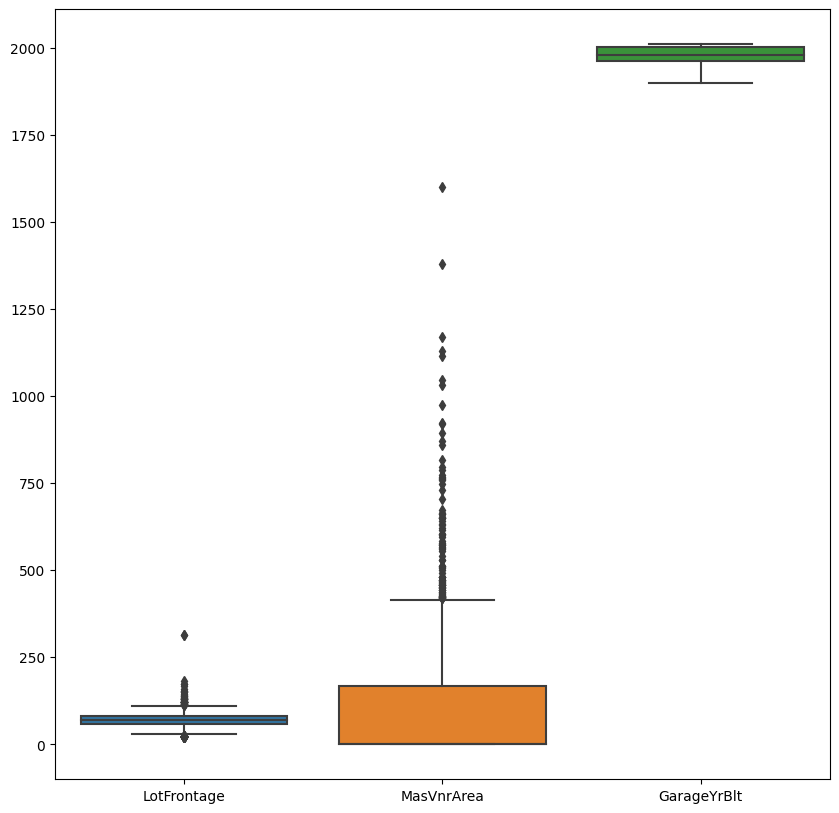

In [194]:
temp = df[cols]
fig = plt.figure(figsize =(10, 10))
sns.boxplot(data = temp)
plt.show()

In [195]:
df.GarageYrBlt.unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [196]:
df.GarageYrBlt.value_counts()

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1927.0     1
1900.0     1
1906.0     1
1908.0     1
1933.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

In [197]:
yrMean = df.GarageYrBlt.value_counts().iloc[:5].index.to_numpy().mean() # mean of the 5 highest common dates

In [198]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(yrMean)

In [199]:
# since the number of missing values for "MasVnrArea" is just 8, we can drop these rows
df = df[df['MasVnrArea'].notna()]

In [200]:
cols = []
for col in df:
    if (df[col].isnull().sum() > 0):
        print(col,":", df[col].isnull().sum())
        cols.append(col)

LotFrontage : 257


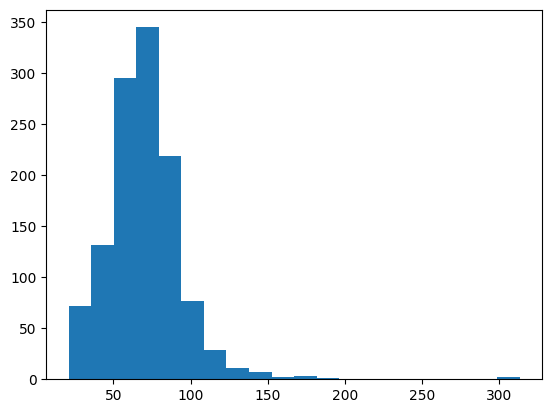

In [201]:
temp = df[cols]
mu, sigma = 0.5, 0.1
for i in range(len(temp.columns)):
    #count, bins, ignored = plt.hist(temp[temp.columns[i]], 20)
    plt.hist(temp[temp.columns[i]], bins=20)
    plt.show()

In [202]:
df.LotFrontage.unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

In [203]:
df.LotFrontage.value_counts()

60.0     143
70.0      70
80.0      69
50.0      57
75.0      52
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: LotFrontage, Length: 110, dtype: int64

In [204]:
topValues = df.LotFrontage.value_counts().iloc[:5]
topValues

60.0    143
70.0     70
80.0     69
50.0     57
75.0     52
Name: LotFrontage, dtype: int64

In [205]:
from scipy.special import softmax

weights = topValues.values / topValues.values.sum() # probability of each unique value
weights

array([0.3657289 , 0.17902813, 0.17647059, 0.14578005, 0.13299233])

In [206]:
lotFrontageWeightedAvg = np.average(list(topValues.index), weights=list(weights)).round()
lotFrontageWeightedAvg

66.0

In [216]:
df['LotFrontage'] = df['LotFrontage'].fillna(lotFrontageWeightedAvg) # don't know why this warning shows up here but not in when imputing GarageYrBlt...

C:\Users\ashra\AppData\Local\Temp\ipykernel_220188\3817798309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'LotFrontage'] = df['LotFrontage'].fillna(lotFrontageWeightedAvg)


In [217]:
cols = []
for col in df:
    if (df[col].isnull().sum() > 0):
        print(col,":", df[col].isnull().sum())
        cols.append(col)

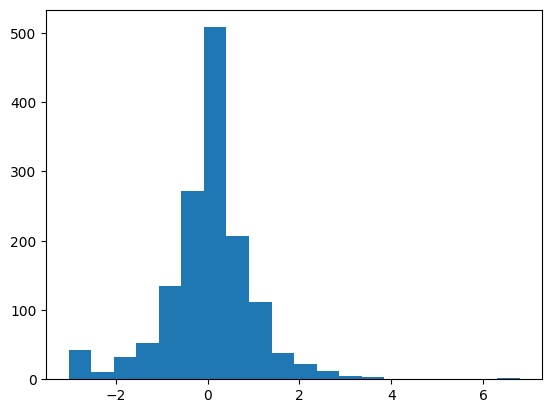

In [208]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
pt.fit(df[cols])                       
pt_data = pt.transform(df[cols])  

df_trans = pd.DataFrame(pt_data, columns=cols) 
for i in range(len(df_trans.columns)):
    plt.hist(df_trans[df_trans.columns[i]], bins=20)
    plt.show()

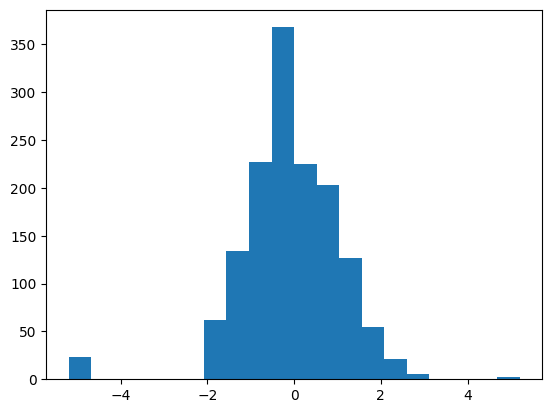

In [209]:
from sklearn.preprocessing import QuantileTransformer
quantile = QuantileTransformer(output_distribution='normal')
data_trans = quantile.fit_transform(df[cols])

pt_data = quantile.transform(df[cols])  

df_trans = pd.DataFrame(pt_data, columns=cols) 
for i in range(len(df_trans.columns)):
    plt.hist(df_trans[df_trans.columns[i]], bins=20)
    plt.show()

C:\Users\ashra\AppData\Local\Temp\ipykernel_220188\3928956251.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation= df.corr()


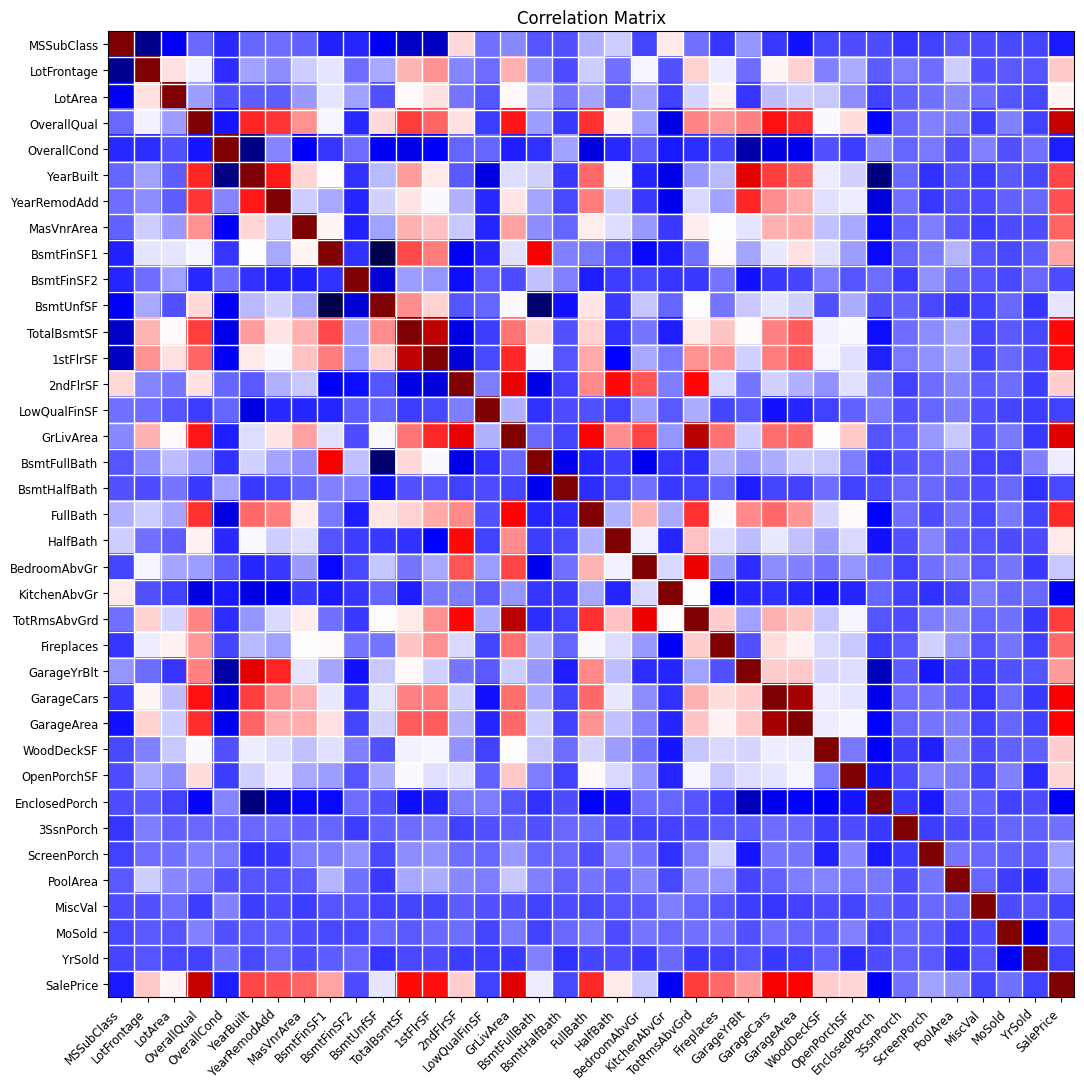

In [210]:
import statsmodels.api as sm
correlation= df.corr()
N, M = 11, 11
fig, ax = plt.subplots(figsize=(N, M))
sm.graphics.plot_corr(correlation, xnames=list(correlation.columns), cmap='seismic', ax=ax)
plt.show()

Noting that `seismic` color-map is this: (left and right are -1, 1 respectively) <br>
<img src="seismicCmap.png" width="400" />

In [211]:
#should we impute the missing values of (MasVnrType) with none? 
# MasVnrArea? BsmtCond with none? 
# BsmtExposure? BsmtFinType1 NA? BsmtFinType2 NA? 
# Drop Electrical? FireplaceQu? 
for col in df:
    if (df[col].isnull().sum() > 0):
        print(col,":", df[col].isnull().sum())

In [212]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,...,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000
mean,56.949036,69.316804,10507.276171,6.092975,5.579201,1971.116391,1984.775482,103.685262,441.970386,46.805785,...,94.416667,46.390496,21.937328,3.428375,15.143939,2.774105,43.728650,6.318182,2007.815427,180615.063361
std,42.340097,22.087138,9989.563592,1.381289,1.113136,30.193761,20.652466,181.066207,455.360279,161.726239,...,125.393706,66.048619,61.089879,29.396943,55.899665,40.287389,497.478278,2.699644,1.328927,79285.541485
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7538.750000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,50.000000,66.000000,9478.500000,6.000000,5.000000,1972.000000,1993.000000,0.000000,381.000000,0.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162700.000000
75%,70.000000,79.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,166.000000,706.500000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [213]:
X = df.iloc[:,0:-1]
y = pd.DataFrame(data=df['SalePrice'])

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [215]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline


rmse_val = []
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)
    pred=model.predict(X_test)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val.append(error)
    print('RMSE value for k= ' , K , 'is:', error)

ValueError: could not convert string to float: 'RM'

In [ ]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train,y_train)
model.best_params_

In [ ]:
X = df.iloc[:, 0].values.reshape(-1, 1) 
Y = df.iloc[:, 1].values.reshape(-1,1) 
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)